In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

from dotenv import load_dotenv
load_dotenv()

True

In [ ]:
def fill_missing_hours(df, date_col, unique_id_col, fill_date, fill_value=0):
    """
    df: Pandas DataFrame containing the data
    date_col: The name of the column in df that contains dates
    unique_id_col: The name of the column in df that contains unique ids
    fill_date: The date until which we should create new rows for missing days
    fill_value: The value to fill in the new rows. Defaults to 0.
    """
    
    # Ensure date is in datetime format
    df[date_col] = pd.to_datetime(df[date_col])

    # Create a new DataFrame to store the filled data
    filled_df = pd.DataFrame()

    df_list = []
    # Loop through each unique id
    for unique_id in df[unique_id_col].unique():
        
        # Filter original DataFrame to only rows of the current unique_id
        unique_id_df = df[df[unique_id_col] == unique_id]

        min_date = unique_id_df[date_col].min()
        
        # Create a DataFrame with all dates from min_date to fill_date for the current unique_id
        date_range_df = pd.DataFrame({
            unique_id_col: unique_id,
            date_col: pd.date_range(start=min_date, end=fill_date, freq='H')
        })

        # Merge date_range_df with unique_id_df
        merged_df = pd.merge(date_range_df, unique_id_df, on=[unique_id_col, date_col], how='left')

        # Append the filled data for the current unique_id to filled_df
        df_list.append(merged_df)

    filled_df = pd.concat(df_list)
    # Fill missing values with fill_value
    filled_df.fillna(fill_value, inplace=True)

    return filled_df

In [ ]:
data = pd.read_csv('./supabase_helnftllsvskaqzkxyyy_requests_per_hour.csv')
data['unique_id'] = 'calls_per_hour'
data['ds'] = pd.to_datetime(data['date_trunc'])
data = data[['unique_id','ds', 'count']]
data = fill_missing_hours(data, 'ds', 'unique_id', data['ds'].max()).reset_index(drop=True)
data = data.tail(24*7).reset_index(drop=True)
data

,unique_id,ds,count
0,calls_per_hour,2023-08-11 01:00:00+00:00,0.0
1,calls_per_hour,2023-08-11 02:00:00+00:00,0.0
2,calls_per_hour,2023-08-11 03:00:00+00:00,0.0
3,calls_per_hour,2023-08-11 04:00:00+00:00,0.0
4,calls_per_hour,2023-08-11 05:00:00+00:00,0.0
...,...,...,...
163,calls_per_hour,2023-08-17 20:00:00+00:00,0.0
164,calls_per_hour,2023-08-17 21:00:00+00:00,0.0
165,calls_per_hour,2023-08-17 22:00:00+00:00,15.0
166,calls_per_hour,2023-08-17 23:00:00+00:00,60.0


Text(0, 0.5, 'Count')

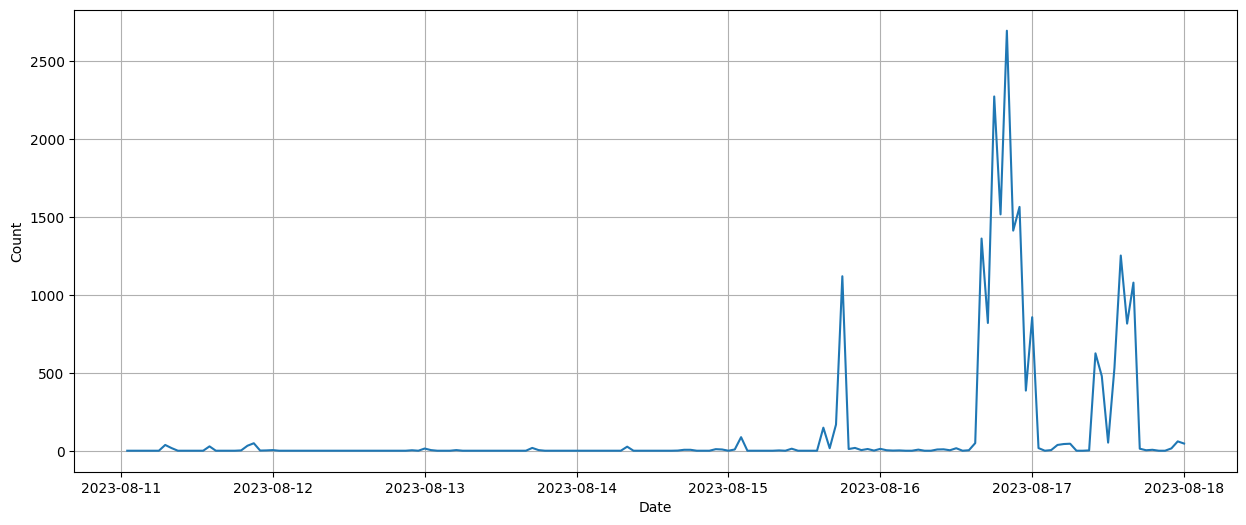

In [ ]:
plt.figure(figsize=(15,6))
plt.plot(data['ds'], data['count'])
plt.grid()
plt.xlabel('Date')
plt.ylabel('Count')

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168 entries, 0 to 167
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype              
---  ------     --------------  -----              
 0   unique_id  168 non-null    object             
 1   ds         168 non-null    datetime64[ns, UTC]
 2   count      168 non-null    float64            
dtypes: datetime64[ns, UTC](1), float64(1), object(1)
memory usage: 4.1+ KB


In [ ]:
import os
from nixtlats import TimeGPT

# Instantiate the `TimeGPT` class providing your credentials.
timegpt = TimeGPT(token=os.environ['TIMEGPT_TOKEN'])

# Check you token is valid and has credits to make requests.
if timegpt.validate_token():
    print("Token validation successful!")
else:
    raise Exception("Token validation failed! Please check go to https://dashboard.nixtla.io/ to get your token.")

# Make a forecast for the next 12 steps (months in this case).
timegpt_fcst_df = timegpt.forecast(df=data, freq='H', level=[95], h=24, time_col='ds', target_col='count')
timegpt_fcst_df['ds'] = pd.to_datetime(timegpt_fcst_df['ds'])

INFO:nixtlats.timegpt:Happy Forecasting! :), If you have questions or need support, please email ops@nixtla.io


Token validation successful!


INFO:nixtlats.timegpt:Validating inputs...
INFO:nixtlats.timegpt:Preprocessing dataframes...
INFO:nixtlats.timegpt:Calling Forecast Endpoint...


In [ ]:
from statsforecast import StatsForecast as sf

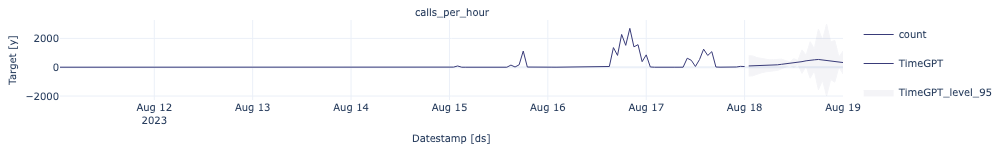

In [ ]:
sf.plot(df=data, forecasts_df=timegpt_fcst_df)

Text(0, 0.5, 'Count')

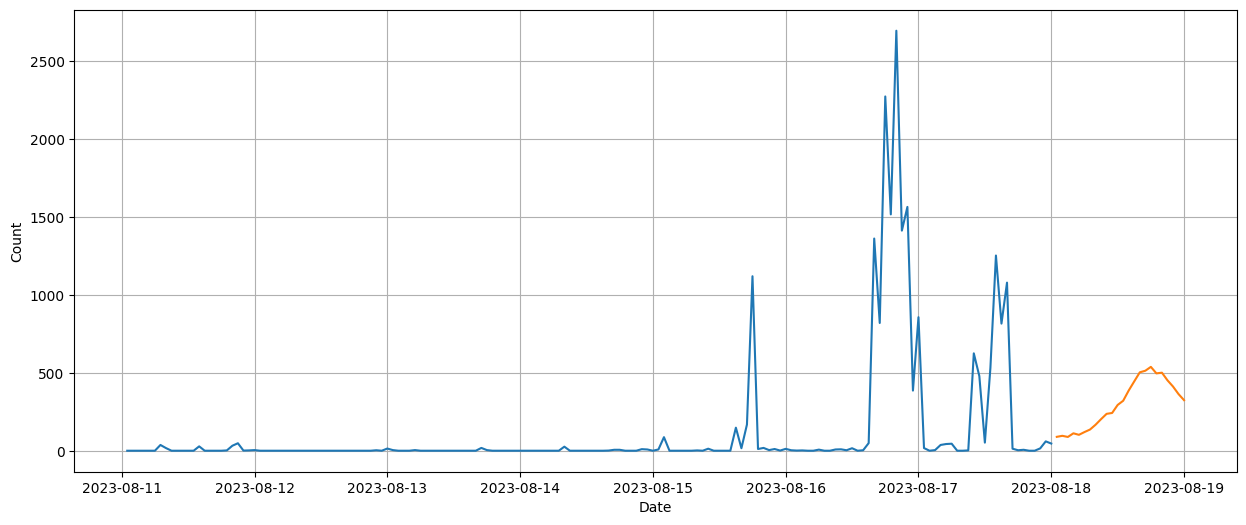

In [ ]:
plt.figure(figsize=(15,6))
plt.plot(data['ds'], data['count'])
plt.plot(timegpt_fcst_df['ds'], timegpt_fcst_df['TimeGPT'])
plt.grid()
plt.xlabel('Date')
plt.ylabel('Count')